In [2]:
import pysam
import pandas as pd
from collections import defaultdict
from scipy.sparse import coo_matrix
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# === 1. Loading metadata from Seurat ===
meta = pd.read_csv("k562.dis.stat.txt", sep="\t", usecols=["cellid", "nCount_RNA", "Phase", "metacell"])
meta = meta.set_index("cellid")

In [5]:
# === 2. Loading Ensembl ID 2 Gene Name ===
gene_map = pd.read_csv("features_mapped.tsv", sep="\t", names=["gene_id", "gene_name"], header=None)
gene_dict = dict(zip(gene_map["gene_id"], gene_map["gene_name"]))

In [6]:
# === 3. Getting gene counts per cell ===
bam = pysam.AlignmentFile("k562.allele.flt.M.bam_filterd.sam.bam", "rb")
gene_cell_counts = defaultdict(lambda: defaultdict(int))

for read in bam:
    if not (read.has_tag("CB") and read.has_tag("GX")):
        continue
    cell = read.get_tag("CB")
    gene = read.get_tag("GX")
    if cell in meta.index:
        gene_cell_counts[cell][gene] += 1

bam.close()

In [7]:
# === 4. Expression matrix ===
all_genes = sorted({g for d in gene_cell_counts.values() for g in d})
all_cells = sorted(gene_cell_counts.keys())
gene_idx = {g: i for i, g in enumerate(all_genes)}
cell_idx = {c: i for i, c in enumerate(all_cells)}

rows, cols, data = [], [], []
for c in all_cells:
    for g, count in gene_cell_counts[c].items():
        rows.append(cell_idx[c])
        cols.append(gene_idx[g])
        data.append(count)

X = coo_matrix((data, (rows, cols)), shape=(len(all_cells), len(all_genes))).tocsc()
df_expr = pd.DataFrame(X.todense(), index=all_cells, columns=all_genes)

In [8]:
# === 5. Normalisation per 10K ===
df_expr_norm = df_expr.div(df_expr.sum(axis=1), axis=0) * 1e4

In [10]:
# === 6. Adding metadata ===
df_expr_norm["Phase"] = meta.loc[df_expr_norm.index, "Phase"]
df_expr_norm["metacell"] = meta.loc[df_expr_norm.index, "metacell"]

In [25]:
# === 6a. Saving tables===
df_expr_norm.to_csv("k562.allele.flt.M_df_expr_norm.tsv", sep="\t")

In [11]:
df_expr_norm

,ENSG00000000457,ENSG00000000460,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001630,ENSG00000002330,...,ENSG00000288075,ENSG00000288091,ENSG00000288093,ENSG00000288156,ENSG00000288253,ENSG00000288321,ENSG00000288380,ENSG00000288398,Phase,metacell
SCG0074_AAACAGCCAAACATAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G1,G1_3
SCG0074_AAACAGCCACCGTTCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S,S_34
SCG0074_AAACAGCCATCGCTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G2M,G2M_35
SCG0074_AAACAGCCATTGTGAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S,S_15
SCG0074_AAACATGCAACATAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S,S_36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCG0080_TTTGTGTTCTACCTCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G1,G1_7
SCG0080_TTTGTGTTCTCAATAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S,S_22
SCG0080_TTTGTTGGTTAGGTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S,S_32
SCG0080_TTTGTTGGTTAGTACG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G2M,G2M_28


In [26]:
# === 7. Agregation: average expression per Phase and Metacell + number of cells ===

numeric_cols = df_expr_norm.select_dtypes(include='number').columns

avg_by_phase = df_expr_norm.groupby("Phase")[numeric_cols].mean()
avg_by_phase["n_cells"] = df_expr_norm.groupby("Phase").size()  # liczba komórek w każdej fazie

avg_by_metacell = df_expr_norm.groupby("metacell")[numeric_cols].mean()
avg_by_metacell["n_cells"] = df_expr_norm.groupby("metacell").size()  # liczba komórek w każdej metakomórce

In [27]:
avg_by_metacell["metacell"] = avg_by_metacell.index.astype(str)

In [28]:
avg_by_metacell

,ENSG00000000457,ENSG00000000460,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001630,ENSG00000002330,...,ENSG00000288075,ENSG00000288091,ENSG00000288093,ENSG00000288156,ENSG00000288253,ENSG00000288321,ENSG00000288380,ENSG00000288398,n_cells,metacell
metacell,,,,,,,,,,,,,,,,,,,,,
G1_0,0.370865,0.305418,0.479272,16.673967,1.539511,0.000000,0.677231,4.841340,0.0,0.0,...,0.000000,0.0,0.0,0.285804,0.0,0.0,0.0,0.48676,321,G1_0
G1_1,0.000000,1.042950,1.038497,10.669787,0.000000,0.000000,0.000000,1.446281,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,330,G1_1
G1_10,0.393871,0.000000,0.000000,16.503420,1.038643,0.577067,0.000000,2.090662,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,403,G1_10
G1_11,0.000000,0.543478,0.000000,13.889672,0.384615,0.735294,0.403226,1.653888,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,400,G1_11
G1_12,0.727167,0.688895,0.384971,16.934428,0.000000,0.000000,0.889090,2.137424,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,382,G1_12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S_5,0.000000,0.828347,0.000000,8.581129,0.366059,0.000000,0.493754,2.276732,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,471,S_5
S_6,0.000000,1.122827,0.000000,11.985345,0.000000,0.000000,1.528651,5.978404,0.0,0.0,...,0.806322,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,477,S_6
S_7,0.934230,0.000000,0.747384,10.128937,0.000000,0.000000,0.605987,1.868460,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,446,S_7


In [29]:
avg_by_phase["Phase"] = avg_by_phase.index.astype(str)

In [30]:
avg_by_phase

,ENSG00000000457,ENSG00000000460,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001630,ENSG00000002330,...,ENSG00000288075,ENSG00000288091,ENSG00000288093,ENSG00000288156,ENSG00000288253,ENSG00000288321,ENSG00000288380,ENSG00000288398,n_cells,Phase
Phase,,,,,,,,,,,,,,,,,,,,,
G1,0.433302,0.545158,0.322822,12.747343,0.702861,0.136286,0.562698,2.124135,0.000000,0.072930,...,0.000000,0.015628,0.000000,0.067966,0.000000,0.000000,0.024075,0.013919,11226,G1
G2M,0.224874,0.819479,0.227182,15.772426,0.438465,0.103787,0.652117,1.861136,0.007735,0.013434,...,0.000000,0.000000,0.000000,0.021988,0.014448,0.000000,0.048342,0.000000,13059,G2M
S,0.182477,0.949821,0.248857,15.235309,0.486928,0.175935,0.533929,2.199175,0.000000,0.025039,...,0.042747,0.000000,0.037211,0.025090,0.000000,0.032296,0.000000,0.000000,16308,S


In [17]:
# === 8. Gene names instead of GeneIDs ===
#named_columnsP = [gene_dict.get(g, g) for g in avg_by_phase.columns]
#named_columnsM = [gene_dict.get(g, g) for g in avg_by_metacell.columns]
#avg_by_phase.columns = named_columnsP
#avg_by_metacell.columns = named_columnsM

In [31]:
# === 9. Saving results===
avg_by_phase.to_csv("k562.allele.flt.M_avg_expression_by_phase.tsv", sep="\t")
avg_by_metacell.to_csv("k562.allele.flt.M_avg_expression_by_metacell.tsv", sep="\t")

In [21]:
# === 1. Distribution of cells per Pseudotime ===
def plot_phase_distribution(avg_by_metacell):
    avg_by_metacell["n_cells"].plot(
        kind='bar',
        color='skyblue',
        title="Number of Cells per Pseudotime"
    )
    plt.xlabel("Cell Cycle Pseudotime")
    plt.ylabel("Number of Cells")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


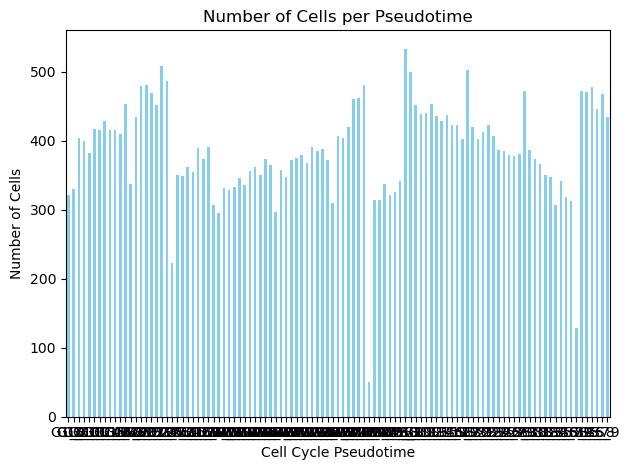

In [22]:
plot_phase_distribution(avg_by_metacell)

In [23]:
# === 2. Distribution of cells per Phase ===
def plot_phase_distribution(avg_by_phase):
    avg_by_phase["n_cells"].plot(
        kind='bar',
        color='skyblue',
        title="Number of Cells per Phase"
    )
    plt.xlabel("Cell Cycle Phase")
    plt.ylabel("Number of Cells")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


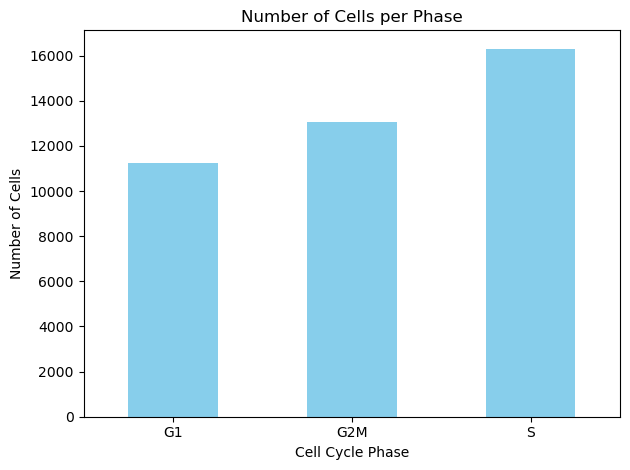

In [24]:
plot_phase_distribution(avg_by_phase)